In [ ]:
import pickle
import zipfile
from google.colab import drive
drive.mount('/content/drive')

# update path to import from Drive
import sys
sys.path.append('content/drive/MyDrive')

import numpy as np
import torch
import matplotlib.pyplot as plt
from torch import nn
from torch.utils.data import Dataset, TensorDataset, DataLoader
import torch.optim as optim
import time
from time import sleep
from tqdm import tqdm

import os

device = 'cuda:0'

use_ellipses = False


Mounted at /content/drive


In [ ]:
folder_path = './'
if use_ellipses:
    data_path = folder_path + 'FFPN-Ellipse-TrainingData-0.015IndividualNoise.pkl'
else:
    data_path = folder_path + 'FFPN-Lodopab-TrainingData-0.015IndividualNoise.pkl'

if os.path.isfile(data_path):
    print("FFPN data .pkl file already exists.")
else:
    print("Extracting data from .pkl file.")
    if use_ellipses:
        with zipfile.ZipFile('/content/drive/MyDrive/FixedPointNetworks/FFPN-Ellipse-TrainingData-IndividualNoise.zip', 'r') as zip_ref:
            zip_ref.extractall('./')
    else:
        with zipfile.ZipFile('/content/drive/MyDrive/FixedPointNetworks/FFPN-Lodopab-TrainingData-IndividualNoise.zip', 'r') as zip_ref:
            zip_ref.extractall('./')        
    print("Extraction complete.")

    sys.path.append('content/drive/MyDrive/FixedPointNetworks')
    sys.path.insert(0,'/content/drive/MyDrive/FixedPointNetworks')  

state = torch.load(data_path)
A = state['A'].to(device)
u_train = state['u_true_train']
u_test = state['u_true_test']
data_obs_train = state['data_obs_train']
data_obs_test = state['data_obs_test']

Extracting data from .pkl file.
Extraction complete.


TV - initial = 12.27
TV - final =  2.94


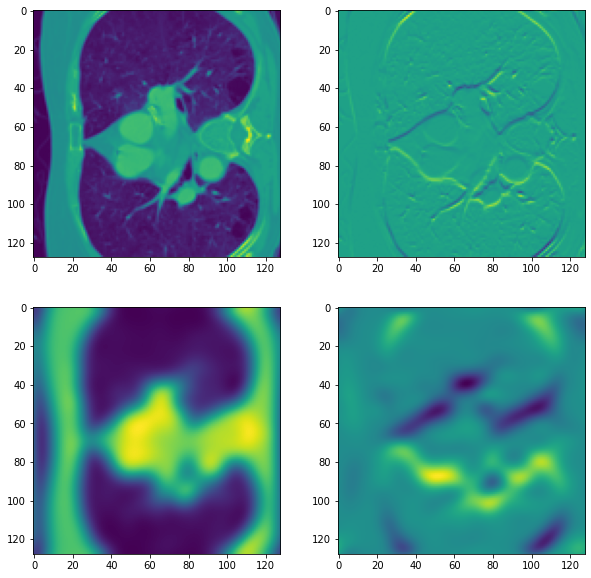

In [ ]:
image = u_train[0,0,:,:]

def grad_TV(u):
    eps = 1.0e-2
    # forward difference
    Dx_u = torch.roll(u, 1, dims=0) - u
    Dy_u = torch.roll(u, 1, dims=1) - u
    # backward difference
    grad_TV_x = Dx_u - torch.roll(Dx_u, -1, dims=0) 
    grad_TV_y = Dy_u - torch.roll(Dy_u, -1, dims=1) 

    grad_num = - (grad_TV_x + grad_TV_y) 
    grad_den = torch.sqrt(Dx_u ** 2.0 + Dy_u ** 2.0 + eps)
    return grad_num / grad_den  

def TV(u): 
    Dx_u = torch.roll(u, 1, dims=0) - u
    Dy_u = torch.roll(u, 1, dims=1) - u 
    TV = torch.sum(Dx_u ** 2.0 + Dy_u ** 2.0) ** 0.5
    return TV


uk = image.clone()
print("TV - initial = {:5.2f}".format(TV(uk)))
for i in range(100):
    uk = uk - 1.0e-2 * grad_TV(uk)
print("TV - final = {:5.2f}".format(TV(uk)))


u0_x_grad = torch.roll(image, 1, dims=0) - image
uk_x_grad = torch.roll(uk, 1, dims=0) - uk

plt.figure(figsize=(10,10))
plt.subplot(2,2,1)
plt.imshow(image)
plt.subplot(2,2,2)
plt.imshow(u0_x_grad)
plt.subplot(2,2,3)
plt.imshow(uk)
plt.subplot(2,2,4)
plt.imshow(uk_x_grad)
#plt.colorbar()

In [ ]:
print("A size = ", A.size())
S = torch.diag(torch.count_nonzero(A, dim=0) ** -1.0).float()
print(S)
print('S size = ', S.size())

A size =  torch.Size([5490, 16384])
tensor([[0.0147, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0143, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0154,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.0149, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0149, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0147]],
       device='cuda:0')
S size =  torch.Size([16384, 16384])


In [ ]:
# Create training datasets

batch_size  = 2
data_train  = TensorDataset(u_train[0:2000,:,:,:], data_obs_train[0:2000,:,:,:])
data_loader = DataLoader(dataset=data_train, batch_size=batch_size, shuffle=True)
n_batches   = int(len(data_loader.dataset)/batch_size)

# Info about the dataset
print()
print(f'u_train.min(): {u_train.min()}')
print(f'u_train.max(): {u_train.max()}')
print("data_obs_train.shape = ", data_obs_train.shape)
print('n_batches = ', n_batches)
#print()*7410


u_train.min(): 0.0
u_train.max(): 1.0
data_obs_train.shape =  torch.Size([20000, 1, 30, 183])
n_batches =  1000


In [ ]:
class TVS_FPN(nn.Module):
    def __init__(self, D, M, beta=0.99, alpha=5.0e-2, 
                 num_TVS_steps=1):
        super().__init__()
        self.TVS_steps = num_TVS_steps
        self.beta = nn.Parameter(beta * torch.ones(1))
        self.alpha = nn.Parameter(alpha * torch.ones(1))
        self.M = M
        self.Mt = M.t()
        self.D = D

    def name(self) -> str:
        return "Regularizer_Net"

    def device(self):
        return next(self.parameters()).data.device

    def grad_TV(self, u):
        eps = 1.0e-2
        # forward difference
        Dx_u = torch.roll(u, 1, dims=-2) - u
        Dy_u = torch.roll(u, 1, dims=-1) - u
        # backward difference
        grad_TV_x = Dx_u - torch.roll(Dx_u, -1, dims=-2) 
        grad_TV_y = Dy_u - torch.roll(Dy_u, -1, dims=-1) 

        grad_num = - (grad_TV_x + grad_TV_y) 
        grad_den = torch.sqrt(Dx_u ** 2.0 + Dy_u ** 2.0 + eps)
        return grad_num / grad_den  

    def _R(self, u, d, beta):
        batch_size = u.shape[0]

        # Gradient Descent Steps
        for _ in range(self.TVS_steps):
            u = u - beta * self.grad_TV(u)
    
        # Constraints Projection
        u_vec = u.view(batch_size, -1).to(self.device())
        u_vec = u_vec.permute(1,0).to(self.device())   
        d = d.view(batch_size,-1).to(self.device())
        d = d.permute(1,0)
        self.M = self.M.to(self.device())
        self.Mt = self.Mt.to(self.device())
        res = self.M.matmul(u_vec)
        res = torch.matmul(self.Mt, res - d)
        res = 1.99 * torch.matmul(self.D, res)
        res = res.permute(1,0)
        res = res.view(batch_size, 1, 128, 128).to(self.device())
        return torch.clamp(u - res, min=-10, max=10)


    def forward(self, d, eps=1.0e-3, max_depth=100, 
                depth_warning=False):
        ''' FPN forward prop
        '''
        self.D = self.D.to(self.device())
        alpha = self.alpha
        self.depth = max_depth
        u = torch.zeros((d.size()[0], 1, 128, 128), device=self.device())

        for _ in range(max_depth):
            u = self._R(u, d, alpha)
            alpha = alpha * self.beta
        return u               

In [ ]:
#-------------------------------------------------------------------------------
# Set up training parameters
#-------------------------------------------------------------------------------

Phi = TVS_FPN(S, A)
Phi = Phi.to(device)

pytorch_total_params = sum(p.numel() for p in Phi.parameters() if p.requires_grad)
print(f'Number of trainable parameters: {pytorch_total_params}')



Number of trainable parameters: 2


In [ ]:
max_epochs    = 10
learning_rate = 1.0e-4 #5.0e-6
max_depth     = 20
eps           = 1.0e-3

criterion = torch.nn.MSELoss()  
optimizer = optim.Adam(Phi.parameters(), lr=learning_rate)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=25, gamma=0.95)

fmt        = '[{:2d}/{:2d}]: train_loss = {:7.3e} | ' 
fmt       += 'depth = {:5.1f} | lr = {:5.1e} | time = {:4.1f} sec'

load_weights = False
if load_weights:
    # FOR RELOADING
    state = torch.load('./drive/MyDrive/FixedPointNetworks/Feasible_FPN_Ellipses_TVS_weights.pth') 
    Phi.load_state_dict(state['Phi_state_dict'])
    print('Loaded Phi from file.')

In [ ]:
#-------------------------------------------------------------------------------
# Execute Training
#-------------------------------------------------------------------------------
best_loss = 1.0e10 

for epoch in range(max_epochs): 
  sleep(0.3)  # slows progress bar so it won't print on multiple lines
  tot = len(data_loader)
  loss_ave = 0.0
  start_time_epoch = time.time() 

  print("\n\nPhi.alpha = ", Phi.alpha)
  print("\nPhi.beta = ", Phi.beta, "\n")

  with tqdm(total=tot, unit=" batch", leave=False, ascii=True) as tepoch:
      
    for idx, (u_batch, d) in enumerate(data_loader): 
      u_batch    = u_batch.to(device) 
      batch_size = u_batch.shape[0]
      train_batch_size = d.shape[0] # re-define if batch size changes
      Phi.train()
      optimizer.zero_grad()
      u = Phi(d, max_depth=max_depth) # add snippet for hiding
      output = criterion(u, u_batch)
      train_loss = output.detach().cpu().numpy()
      loss_ave += train_loss * train_batch_size
      output.backward()
      optimizer.step()

      tepoch.update(1)
      tepoch.set_postfix(train_loss="{:5.2e}".format(train_loss),
                            depth="{:5.1f}".format(Phi.depth))
    
    if epoch%1 == 0:
        # compute test image 
        Phi.eval()
        u_test_approx = Phi(data_obs_test[0:1, :, :, :], max_depth=max_depth, eps=eps)

        plt.figure()
        plt.subplot(2,2,1)
        plt.imshow(u_batch[0,0,:,:].cpu(), vmin=0, vmax=1)
        plt.title('u true train')
        plt.subplot(2,2,2)
        plt.imshow(u[0,0,:,:].detach().cpu(), vmin=0, vmax=1)
        plt.title('u approx train')
        plt.subplot(2,2,3)
        plt.imshow(u_test[0,0,:,:].cpu(), vmin=0, vmax=1)
        plt.title('u true test')
        plt.subplot(2,2,4)
        plt.imshow(u_test_approx[0,0,:,:].detach().cpu(), vmin=0, vmax=1)
        plt.title('u approx test')
        plt.show() 

        Phi.train() 
    
  loss_ave = loss_ave/len(data_loader.dataset)
  end_time_epoch = time.time()
  time_epoch = end_time_epoch - start_time_epoch
  lr_scheduler.step()
  print(fmt.format(epoch+1, max_epochs, loss_ave, Phi.depth, 
                   optimizer.param_groups[0]['lr'],
                   time_epoch))

In [ ]:
# TENTATIVE PARAMETERS
# 0.0023 = beta
# 0.9680 = decay

# Validation 
n_samples = u_test.shape[0]

data_test     = TensorDataset(u_test, data_obs_test)
test_data_loader     = DataLoader(dataset=data_test, batch_size=batch_size, shuffle=True)



In [ ]:
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr

def compute_avg_SSIM_PSNR(u_true, u_gen, n_mesh, data_range):
    # assumes images are size n_samples x n_features**2 and are detached
    n_samples = u_true.shape[0]
    u_true = u_true.reshape(n_samples, n_mesh, n_mesh).cpu().numpy()
    u_gen  = u_gen.reshape(n_samples, n_mesh, n_mesh).cpu().numpy()
    ssim_val = 0
    psnr_val = 0
    for j in range(n_samples):
        ssim_val = ssim_val + ssim(u_true[j,:,:], u_gen[j,:,:], data_range=data_range)
        psnr_val = psnr_val + psnr(u_true[j,:,:], u_gen[j,:,:], data_range=data_range)
    return ssim_val/n_samples, psnr_val/n_samples

In [ ]:


test_loss_ave = 0
test_PSNR_ave = 0
test_SSIM_ave = 0
with torch.no_grad():
    for idx, (u_batch, d) in enumerate(test_data_loader): 

        u_batch    = u_batch.to(device) 
        batch_size = u_batch.shape[0]
        temp       = u_batch.view(batch_size, -1)
        temp       = temp.permute(1,0)        
        test_batch_size = d.shape[0] # re-define if batch size changes
        Phi.eval()
        u = Phi(d, max_depth=max_depth, eps=eps) # add snippet for hiding
        output = criterion(u, u_batch)
        test_loss = output.detach().cpu().numpy()
        test_SSIM, test_PSNR = compute_avg_SSIM_PSNR(u_batch, u, 128, 1)
        test_PSNR_ave += test_PSNR * test_batch_size
        test_loss_ave += test_loss * test_batch_size
        test_SSIM_ave += test_SSIM * test_batch_size

        print('test_PSNR = {:7.3e}'.format(test_PSNR))
        print('test_SSIM = {:7.3e}'.format(test_SSIM))
        print('test_loss = {:7.3e}'.format(test_loss))
        if idx%1 == 0:
            # compute test image 
            plt.figure()
            plt.subplot(1,2,1)
            plt.imshow(u_batch[0,0,:,:].cpu(), vmin=0, vmax=1)
            plt.title('u true')
            plt.subplot(1,2,2)
            plt.imshow(u[0,0,:,:].detach().cpu(), vmin=0, vmax=1)
            plt.title('u approx')
            plt.show()  

print('\n\nSUMMARY')
print('test_loss_ave =  {:7.3e}'.format(test_loss_ave / 1000))
print('test_PSNR_ave =  {:7.3e}'.format(test_PSNR_ave / 1000))
print('test_SSIM_ave =  {:7.3e}'.format(test_SSIM_ave / 1000))

In [ ]:
if use_ellipses:
    ind_val = 0
else:
    ind_val = 1000

u = Phi(data_obs_test[ind_val,:,:,:], max_depth=max_depth).view(128,128)
u_true = u_test[ind_val,0,:,:]
def string_ind(index):
    if index < 10:
        return '000' + str(index)
    elif index < 100:
        return '00' + str(index)
    elif index < 1000:
        return '0' + str(index)
    else:
        return str(index)

cmap = 'gray'
fig = plt.figure()
plt.imshow(np.rot90(u.detach().cpu().numpy()),cmap=cmap, vmin=0, vmax=1)
plt.axis('off')

data_type = 'Ellipse' if use_ellipses else 'Lodopab'

save_loc = './drive/MyDrive/FixedPointNetworks/Learned_Feasibility_' + data_type + '_TVM_ind_' + string_ind(ind_val) + '.pdf'
plt.savefig(save_loc,bbox_inches='tight')
plt.show()

print("SSIM: ", compute_avg_SSIM_PSNR(u_true.view(1,128,128), u.view(1,128,128).detach(), 128, 1))

############
# TRUE
###########

cmap = 'gray'
fig = plt.figure()
plt.imshow(np.rot90(u_true.detach().cpu().numpy()),cmap=cmap, vmin=0, vmax=1)
plt.axis('off')


save_loc = './drive/MyDrive/FixedPointNetworks/Learned_Feasibility_' + data_type + '_GT_ind_' + string_ind(ind_val) + '.pdf'
plt.savefig(save_loc,bbox_inches='tight')
plt.show()